The Community Aerosol and Radiation Model for Atmospheres, [CARMA](https://github.com/ESCOMP/CARMA), can be configured and run through musica. This tutorial walks through creating two small carma test..

First, we need to import our packages

In [1]:
import musica
import ussa1976
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from musica.constants import GAS_CONSTANT
import musica.mechanism_configuration as mc
import pandas as pd

# Aluminum

The first test is a coagulation test for aluminum in 5 bins. Please note that all input data going into the musica carma package should be in SI units, so meters instead of centimeters, pascal instead of hectapascals, etc. Anytime CARMA would be expecting a different unit, the musica package will automatically make that conversion when configuring carma.

First up, we create the groups and elements, and create our carma paramters class. This is then used to make an instance of CARMA.

In [2]:
group = musica.carma.CARMAGroupConfig(
    name="aluminum",
    shortname="PRALUM",
    rmrat=2.0,
    rmin=21.5e-6,
    rmon=21.5e-6,
    ishape=musica.carma.ParticleShape.SPHERE,
    eshape=1.0,
    mie_calculation_algorithm=musica.carma.MieCalculationAlgorithm.TOON_1981,
    is_ice=False,
    is_fractal=True,
    do_wetdep=False,
    do_drydep=True,
    do_vtran=True,
    solfac=0.0,
    scavcoef=0.0,
    df=[1.6] * 5,  # 5 bins with fractal dimension 1.6
    falpha=1.0
)

# Create aluminum element
element = musica.carma.CARMAElementConfig(
    igroup=1,
    isolute=0,
    name="Aluminum",
    shortname="ALUM",
    itype=musica.carma.ParticleType.INVOLATILE,
    icomposition=musica.carma.ParticleComposition.ALUMINUM,
    rho=0.00395,  # kg/m3
    arat=[1.0] * 5,  # 5 bins with area ratio 1.0
    kappa=0.0,
)

# Create coagulation
coagulation = musica.carma.CARMACoagulationConfig(
    igroup1=1,
    igroup2=1,
    igroup3=1,
    algorithm=musica.carma.ParticleCollectionAlgorithm.FUCHS)

params = musica.carma.CARMAParameters(
    nbin=5,
    nz=1,
    dtime=1800.0,
    groups=[group],
    elements=[element],
    coagulations=[coagulation]
)

FIVE_DAYS_IN_SECONDS = 432000
params.nstep = FIVE_DAYS_IN_SECONDS // params.dtime
params.initialization.do_vtran = False

carma = musica.carma.CARMA(params)

Next, we make some envionrmental data which we will use to initialize our state.

In [3]:
n_levels = params.nz
deltaz = 1000.0
zmin = 16500.0

vertical_center = zmin + (np.arange(n_levels) + 0.5) * deltaz
vertical_levels = zmin + np.arange(n_levels + 1) * deltaz

centered_variables = ussa1976.compute(z=vertical_center, variables=["t", "p", "rho"])
edge_variables = ussa1976.compute(z=vertical_levels, variables=["p"])

temperature = centered_variables.t.values
pressure = centered_variables.p.values
pressure_levels = edge_variables.p.values
density = centered_variables.rho.values

Finally, we will run the carma box model. While the model runs, we will also collect the data. At the end we will combine it all into one xarray dataset.

In [4]:
mmr_initial = 5e9 / (deltaz * 2.57474699e14) / density[0]

state = carma.create_state(
    time_step=params.dtime,
    temperature=temperature,
    pressure=pressure,
    pressure_levels=pressure_levels,
    vertical_center=vertical_center,
    vertical_levels=vertical_levels,
    longitude=0.0,
    latitude=-105.0,
    coordinates=musica.carma.CarmaCoordinates.CARTESIAN,
)

for i in range(params.nbin):
    for j in range(len(params.elements)):
        state.set_bin(i + 1, j + 1, mmr_initial)

bin_data = state.get_bins()
bin_data = bin_data.expand_dims({"time": [0]})
env = state.get_environmental_values()
env = env.expand_dims({"time": [0]})
time_array = [0.0]  # Start with time 0

# Run the simulation for the specified number of steps
for step in range(1, int(params.nstep)):
    state.step()
    bin_data = xr.concat([bin_data, state.get_bins().expand_dims({"time": [step * params.dtime]})], dim="time")
    env = xr.concat([env, state.get_environmental_values().expand_dims(
        {"time": [step * params.dtime]})], dim="time")
    time_array.append(step * params.dtime)

ds = xr.merge([bin_data, env])

In [5]:
ds

<xarray.Dataset> Size: 154kB
Dimensions:                     (time: 240, bin: 5, element: 1,
                                 vertical_center: 1, vertical_level: 2)
Coordinates:
  * time                        (time) float64 2kB 0.0 1.8e+03 ... 4.302e+05
  * bin                         (bin) int64 40B 1 2 3 4 5
  * element                     (element) int64 8B 1
  * vertical_center             (vertical_center) float64 8B 1.7e+04
  * vertical_level              (vertical_level) float64 16B 1.65e+04 1.75e+04
Data variables: (12/18)
    mass_mixing_ratio           (time, bin, element, vertical_center) float64 10kB ...
    number_mixing_ratio         (time, bin, element, vertical_center) float64 10kB ...
    number_density              (time, bin, element, vertical_center) float64 10kB ...
    nucleation_rate             (time, bin, element, vertical_center) float64 10kB ...
    wet_particle_radius         (time, bin, element, vertical_center) float64 10kB ...
    wet_particle_density        (time, bin, element, vertical_center) float64 10kB ...
    ...                          ...
    sedimentation_flux          (time, bin, element) float64 10kB 0.0 ... 0.0
    deposition_velocity         (time, bin, element) float64 10kB -9.99 ... -...
    temperature                 (time, vertical_center) float64 2kB 216.6 ......
    pressure                    (time, vertical_center) float64 2kB 8.85e+03 ...
    air_density                 (time, vertical_center) float64 2kB 0.1417 .....
    latent_heat                 (time, vertical_center) object 2kB None ... None

Now we will make as serices of plots, but first we will transform the time from seconds to days to make the plotting labels nicer.

In [6]:
# convert from seconds to days
ds = ds.assign_coords(time=ds.time / 86400)

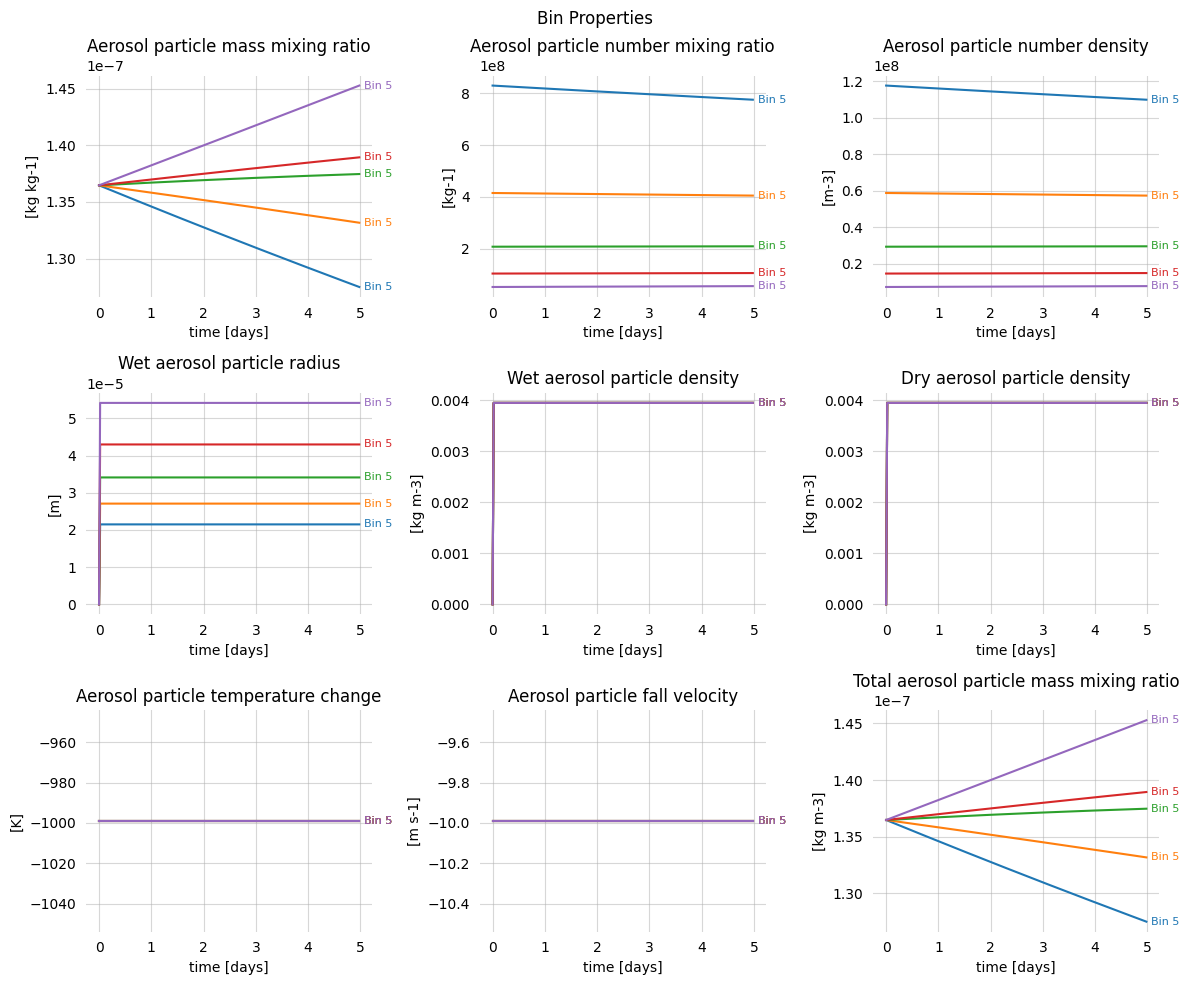

In [7]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=3)

vars = [
    'mass_mixing_ratio', 'number_mixing_ratio', 'number_density', 
    'wet_particle_radius', 'wet_particle_density', 'dry_particle_density',
    'delta_particle_temperature', 'fall_velocity', 'total_mass_mixing_ratio'
]

for var, ax in zip(vars, axs.ravel()):
    for bin in ds.bin.values:
        y = ds[var].sel(bin=bin).isel(element=0)
        if 'vertical_level' in y.coords:
            y = y.isel(vertical_level=0)
        else:
            y = y.isel(vertical_center=0)
        line, = ax.plot(ds.time, y, label=f'Bin {i+1}')
        buffer = (ds.time.values[-1] - ds.time.values[-2]) * 4.50
        ax.text(ds.time.values[-1] + buffer, y.values[-1], f'Bin {i+1}',
                va='center', ha='left', fontsize=8, color=line.get_color())
    
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('time [days]')
    ax.set_ylabel(f'[{ds[var].units}]')
    ax.set_title(f'{ds[var].long_name}')
    
fig.suptitle("Bin Properties")
fig.tight_layout()

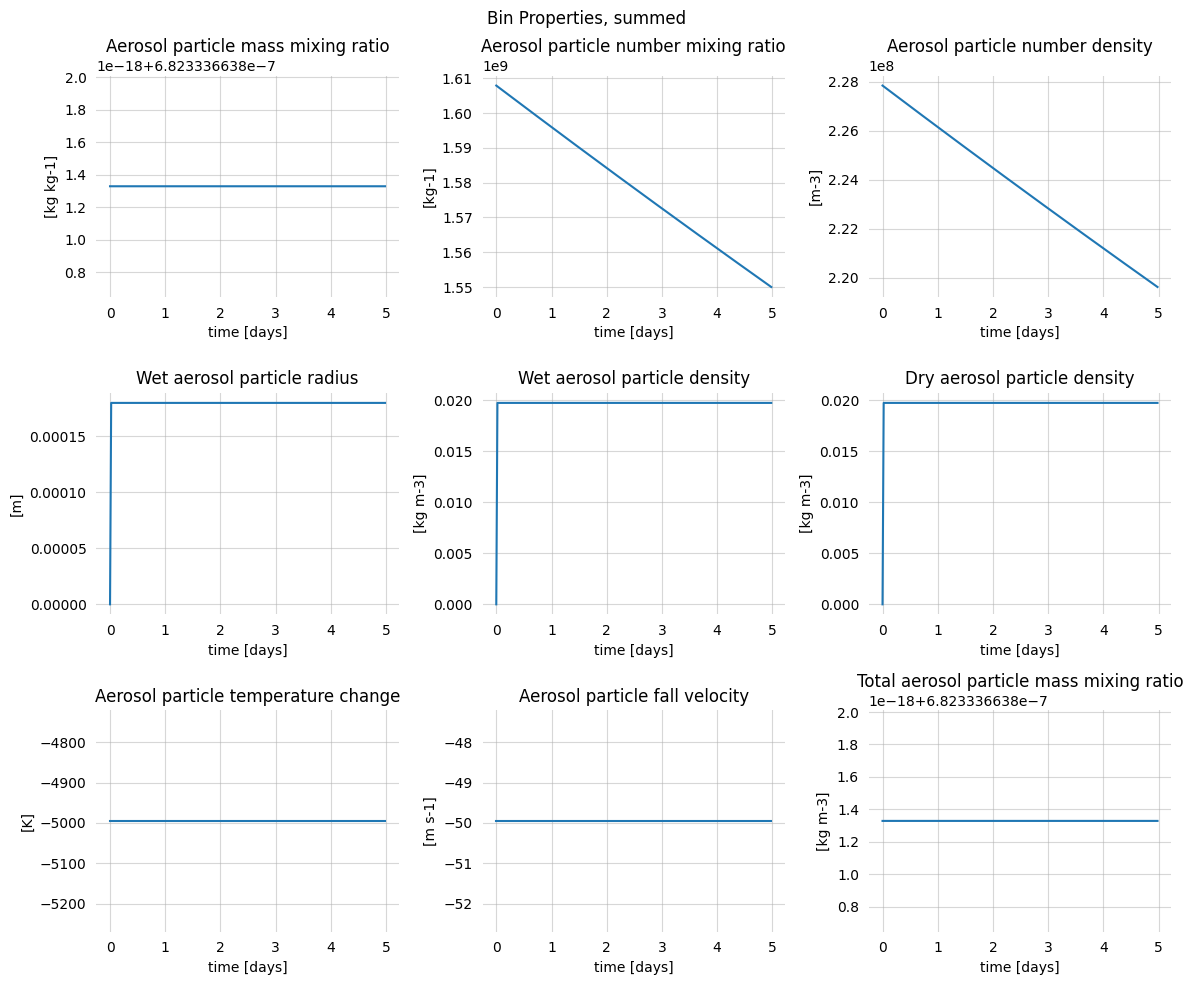

In [8]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=3)

vars = [
    'mass_mixing_ratio', 'number_mixing_ratio', 'number_density', 
    'wet_particle_radius', 'wet_particle_density', 'dry_particle_density',
    'delta_particle_temperature', 'fall_velocity', 'total_mass_mixing_ratio'
]

for var, ax in zip(vars, axs.ravel()):
    ax.plot(ds.time, ds[var].sum(dim='bin')[:, 0, 0])
    
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('time [days]')
    ax.set_ylabel(f'[{ds[var].units}]')
    ax.set_title(f'{ds[var].long_name}')
    
fig.suptitle("Bin Properties, summed")
fig.tight_layout()

In [9]:
group_props, group_config = carma.get_group_properties()

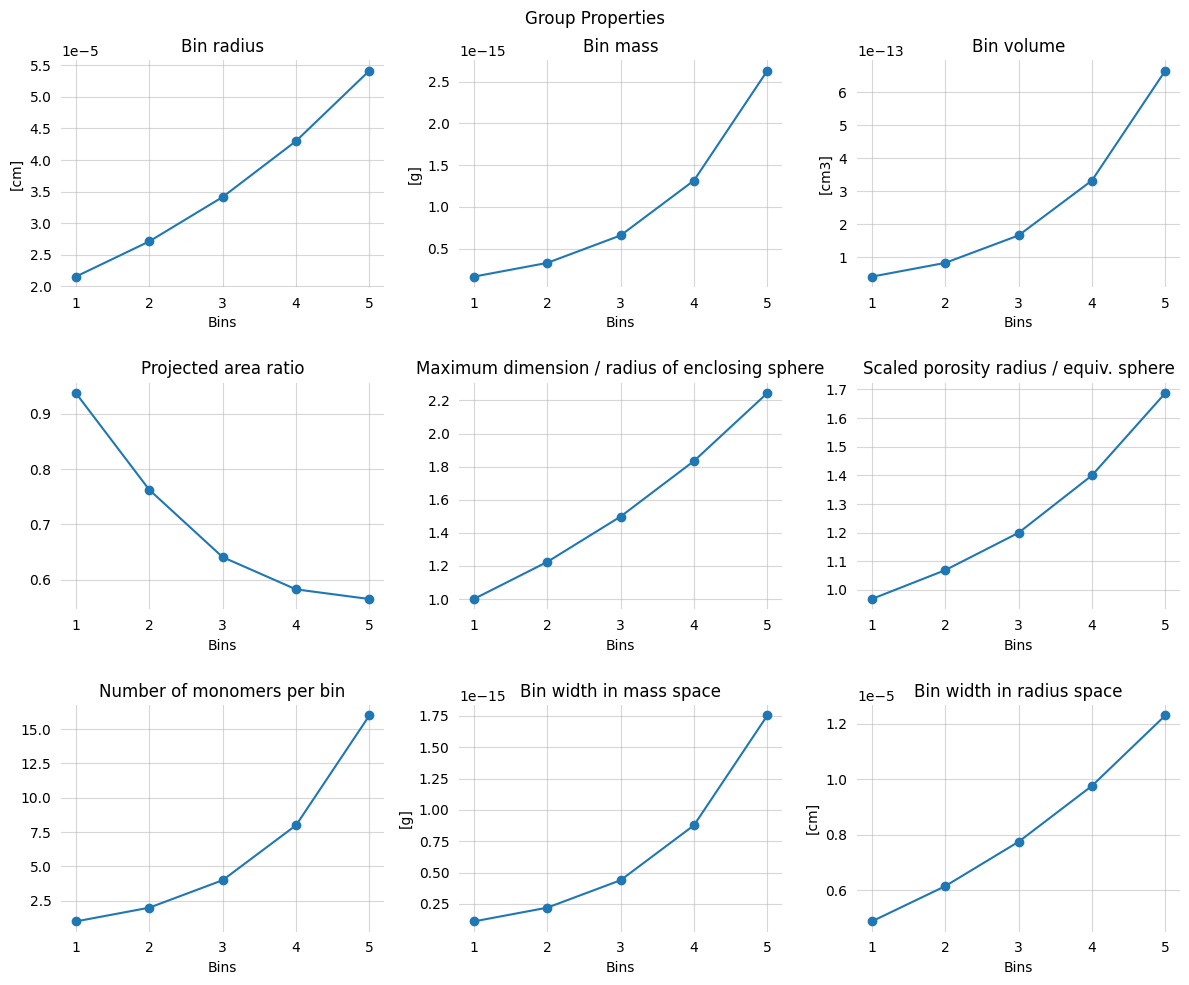

In [10]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=3)

vars = [
    'bin_radius', 'bin_mass', 'bin_volume', 
    'projected_area_ratio', 'radius_ratio', 'porosity_ratio',
    'number_of_monomers_per_bin', 'bin_width_mass', 'bin_width'
]

name_to_label = {
    "bin_radius": "Bin radius",
    "bin_radius_lower_bound": "Lower bound of bin radius",
    "bin_radius_upper_bound": "Upper bound of bin radius",
    "bin_width": "Bin width in radius space",
    "bin_mass": "Bin mass",
    "bin_width_mass": "Bin width in mass space",
    "bin_volume": "Bin volume",
    "projected_area_ratio": "Projected area ratio",
    "radius_ratio": "Maximum dimension / radius of enclosing sphere",
    "porosity_ratio": "Scaled porosity radius / equiv. sphere",
    "extinction_coefficient": "Extinction coefficient",
    "single_scattering_albedo": "Single scattering albedo",
    "asymmetry_factor": "Asymmetry factor",
    "particle_number_element_for_group": "Index of element for particle number",
    "number_of_core_mass_elements_for_group": "Number of core mass elements",
    "element_index_of_core_mass_elements": "Indices of core mass elements",
    "last_prognostic_bin": "Last prognostic bin",
    "number_of_monomers_per_bin": "Number of monomers per bin"
}
name_to_units = {
    "bin_radius": "cm",
    "bin_radius_lower_bound": "cm",
    "bin_radius_upper_bound": "cm",
    "bin_width": "cm",
    "bin_mass": "g",
    "bin_width_mass": "g",
    "bin_volume": "cm3",
    "projected_area_ratio": "",
    "radius_ratio": "",
    "porosity_ratio": "",
    "extinction_coefficient": "m-1",
    "single_scattering_albedo": "",
    "asymmetry_factor": "",
    "particle_number_element_for_group": "",
    "number_of_core_mass_elements_for_group": "",
    "element_index_of_core_mass_elements": "",
    "last_prognostic_bin": "",
    "number_of_monomers_per_bin": ""
}

for var, ax in zip(vars, axs.ravel()):
    line, = ax.plot(group_props[var].sel(group=1), marker='o')
    
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('Bins')
    ax.set_xticks(range(5))
    ax.set_xticklabels([1, 2, 3, 4, 5])
    if name_to_units[var]:
        ax.set_ylabel(f'[{name_to_units[var]}]')
    ax.set_title(f'{name_to_label[var]}')

fig.suptitle("Group Properties")
    
fig.tight_layout()

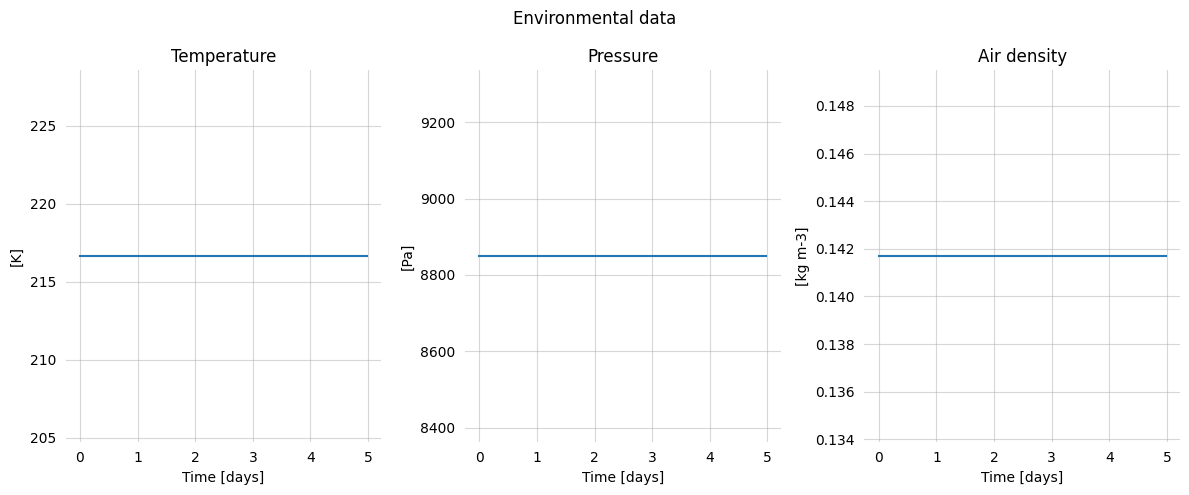

In [11]:
fig, axs = plt.subplots(figsize=(12, 5), nrows=1, ncols=3)

vars = [
    'temperature', 'pressure', 'air_density'
]

for var, ax in zip(vars, axs.ravel()):
    line, = ax.plot(ds.time, ds[var])
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(f'[{ds[var].units}]')
    ax.set_title(f'{ds[var].long_name}')

fig.suptitle("Environmental data")
    
fig.tight_layout()

# Sulfate

This next model is more complex and tests sulfate.

First up we define the paramters to configure sulfate.

In [12]:
GRAVITY = 9.806  # Acceleration due to gravity in m/s^2

# Simplified constants for debugging
NZ = 1
NELEM = 1
NBIN = 38

dtime = 1800.0  # Time step in seconds
deltaz = 10000.0  # Grid box height in meters
nsteps = int(180000 / dtime)

# Sulfate density
rho_sulfate_kg_m3 = 1923.0  # kg/m³

# Grid setup
latitude = -40.0
longitude = -105.0
vertical_center = [17000.0]
vertical_levels = [vertical_center[0] - deltaz, vertical_center[0] + deltaz]

# Standard atmosphere
pressure_centers = np.array([9000.0])
temperature_centers = np.array([250.0])
# this is directly from the original CARMA test, but it seems like there are some unit conversion issues
air_mass_density_centers = pressure_centers * 10.0 / (8.31430e07 / 28.966 * temperature_centers) * (1.0e-3 * 1.0e6)
pressure_levels = np.zeros(2)
pressure_levels[0] = pressure_centers[0] - \
    (vertical_levels[0] - vertical_center[0]) * air_mass_density_centers[0] * GRAVITY
pressure_levels[1] = pressure_centers[0] - \
    (vertical_levels[1] - vertical_center[0]) * air_mass_density_centers[0] * GRAVITY

# Initial mass mixing ratios
mass_mixing_ratios = {
    "H2O": [1.0e-4],
    "H2SO4": [0.1e-9 * (98.0 / 29.0)],
    "SULFATE": [[0.0 for _ in range(NBIN)]]
}
satliq = {
    "H2O": [-1.0],
    "H2SO4": [-1.0]
}
satice = {
    "H2O": [-1.0],
    "H2SO4": [-1.0]
}

# Set up CARMA parameters
params = musica.carma.CARMAParameters()
params.nz = NZ
params.nbin = NBIN

# Create sulfate group - simplified
sulfate_group = musica.carma.CARMAGroupConfig(
    name="sulfate",
    shortname="SULF",
    rmin=2.e-10,  # Minimum radius in m
    rmrat=2.0,   # Mass ratio between bins
    swelling_approach={
        "algorithm": musica.carma.ParticleSwellingAlgorithm.WEIGHT_PERCENT_H2SO4,
        "composition": musica.carma.ParticleSwellingComposition.NONE
    },
    do_drydep=True,
    is_sulfate=True
)
params.add_group(sulfate_group)

# Create sulfate element
sulfate_element = musica.carma.CARMAElementConfig(
    igroup=1,
    name="Sulfate",
    shortname="SULF",
    rho=rho_sulfate_kg_m3,
    itype=musica.carma.ParticleType.VOLATILE,
    icomposition=musica.carma.ParticleComposition.SULFURIC_ACID
)
params.add_element(sulfate_element)

# Create gases - simplified to match successful test_carma.py pattern
water_gas = musica.carma.CARMAGasConfig(
    name="Water Vapor",
    shortname="H2O",
    wtmol=0.018015,  # kg/mol
    ivaprtn=musica.carma.VaporizationAlgorithm.H2O_MURPHY_2005,
    icomposition=musica.carma.GasComposition.H2O,
    dgc_threshold=0.1,
    ds_threshold=0.1
)
params.add_gas(water_gas)

# Create H2SO4 gas
h2so4_gas = musica.carma.CARMAGasConfig(
    name="Sulfuric Acid",
    shortname="H2SO4",
    wtmol=0.098079,  # kg/mol
    ivaprtn=musica.carma.VaporizationAlgorithm.H2SO4_AYERS_1980,
    icomposition=musica.carma.GasComposition.H2SO4,
    dgc_threshold=0.1,
    ds_threshold=0.1
)
params.add_gas(h2so4_gas)

# Add growth process
growth = musica.carma.CARMAGrowthConfig(
    ielem=1,  # Sulfate element
    igas=2    # H2SO4 gas
)
params.add_growth(growth)

# Add nucleation process
nucleation = musica.carma.CARMANucleationConfig(
    ielemfrom=1,
    ielemto=1,
    algorithm=musica.carma.ParticleNucleationAlgorithm.HOMOGENEOUS_NUCLEATION,
    rlh_nuc=0.0,
    igas=2  # H2SO4 gas
)
params.add_nucleation(nucleation)

# Add coagulation
coagulation = musica.carma.CARMACoagulationConfig(
    igroup1=1,
    igroup2=1,
    igroup3=1,
    algorithm=musica.carma.ParticleCollectionAlgorithm.FUCHS
)
params.add_coagulation(coagulation)

# Initialization
params.initialization.do_substep = True
params.initialization.do_thermo = True
params.initialization.maxretries = 16
params.initialization.maxsubsteps = 32
params.initialization.dt_threshold = 1.0
params.initialization.sulfnucl_method = musica.carma.SulfateNucleationMethod.ZHAO_TURCO.value

# Create CARMA instance
carma = musica.carma.CARMA(params)

Next we print out some group properties for each bin

In [13]:
# Output group properties
group_props, _ = carma.get_group_properties()
# Print bin radius and bin mass from group_props xarray Dataset
for i_bin in range(NBIN):
    print(
        f"Bin {i_bin + 1}: bin radius = {group_props.isel(bin=i_bin)['bin_radius'].values[0]}; bin mass = {group_props.isel(bin=i_bin)['bin_mass'].values[0]}"
    )

Bin 1: bin radius = 1.9999999552965185e-10; bin mass = 6.444035157118609e-26
Bin 2: bin radius = 2.519842043466889e-10; bin mass = 1.2888070314237217e-25
Bin 3: bin radius = 3.1748020329740454e-10; bin mass = 2.5776140628474434e-25
Bin 4: bin radius = 3.999999910593037e-10; bin mass = 5.155228125694887e-25
Bin 5: bin radius = 5.039684086933778e-10; bin mass = 1.0310456251389774e-24
Bin 6: bin radius = 6.349604065948091e-10; bin mass = 2.0620912502779548e-24
Bin 7: bin radius = 7.999999821186074e-10; bin mass = 4.1241825005559095e-24
Bin 8: bin radius = 1.0079368173867555e-09; bin mass = 8.248365001111819e-24
Bin 9: bin radius = 1.2699208131896181e-09; bin mass = 1.6496730002223638e-23
Bin 10: bin radius = 1.5999999642372146e-09; bin mass = 3.2993460004447276e-23
Bin 11: bin radius = 2.015873634773511e-09; bin mass = 6.598692000889455e-23
Bin 12: bin radius = 2.5398416263792355e-09; bin mass = 1.319738400177891e-22
Bin 13: bin radius = 3.199999928474429e-09; bin mass = 2.639476800355782

Finally, we will run the box model.

In [14]:
bin_state = None
gas_state = None
env_state = None

for i_step in range(nsteps):

    # Create state
    state = carma.create_state(
        time_step=dtime,
        temperature=temperature_centers,
        original_temperature=temperature_centers,
        pressure=pressure_centers,
        pressure_levels=pressure_levels,
        vertical_center=vertical_center,
        vertical_levels=vertical_levels,
        longitude=longitude,
        latitude=latitude,
        coordinates=musica.carma.CarmaCoordinates.CARTESIAN,
        specific_humidity=mass_mixing_ratios["H2O"],
    )

    # Initialize particle concentrations to zero
    for ibin in range(1, NBIN + 1):
        for ielem in range(1, NELEM + 1):
            state.set_bin(ibin, ielem, mass_mixing_ratios["SULFATE"][0][ibin - 1])

    # Set H2O concentration
    state.set_gas(
        gas_index=1,
        value=mass_mixing_ratios["H2O"],
        old_mmr=mass_mixing_ratios["H2O"],
        gas_saturation_wrt_ice=satice["H2O"],
        gas_saturation_wrt_liquid=satliq["H2O"],
    )

    # Set H2SO4 concentration
    state.set_gas(
        gas_index=2,
        value=[mmr * 1.05 for mmr in mass_mixing_ratios["H2SO4"]],
        old_mmr=mass_mixing_ratios["H2SO4"],
        gas_saturation_wrt_ice=satice["H2SO4"],
        gas_saturation_wrt_liquid=satliq["H2SO4"],
    )

    # Perform model step
    state.step()

    # Get updated state values
    if bin_state is None:
        bin_state = state.get_bins()
        bin_state = bin_state.expand_dims({"time": [i_step * dtime]})
    else:
        bin_state = xr.concat([bin_state, state.get_bins().expand_dims({"time": [i_step * dtime]})], dim="time")

    if gas_state is None:
        gas_state = state.get_gases()[0]
        gas_state = gas_state.expand_dims({"time": [i_step * dtime]})
    else:
        gas_state = xr.concat([gas_state, state.get_gases()[0].expand_dims({"time": [i_step * dtime]})], dim="time")

    if env_state is None:
        env_state = state.get_environmental_values()
        env_state = env_state.expand_dims({"time": [i_step * dtime]})
    else:
        env_state = xr.concat([env_state, state.get_environmental_values(
        ).expand_dims({"time": [i_step * dtime]})], dim="time")

In [15]:
ds = xr.merge([bin_data, env_state, gas_state])

In [16]:
ds

<xarray.Dataset> Size: 177kB
Dimensions:                         (time: 240, bin: 5, element: 1,
                                     vertical_center: 1, vertical_level: 2,
                                     gas: 2)
Coordinates:
  * time                            (time) float64 2kB 0.0 1.8e+03 ... 4.302e+05
  * bin                             (bin) int64 40B 1 2 3 4 5
  * element                         (element) int64 8B 1
  * vertical_center                 (vertical_center) float64 8B 1.7e+04
  * vertical_level                  (vertical_level) float64 16B 1.65e+04 1.7...
  * gas                             (gas) <U5 40B 'H2O' 'H2SO4'
Data variables: (12/24)
    mass_mixing_ratio               (time, bin, element, vertical_center) float64 10kB ...
    number_mixing_ratio             (time, bin, element, vertical_center) float64 10kB ...
    number_density                  (time, bin, element, vertical_center) float64 10kB ...
    nucleation_rate                 (time, bin, element, vertical_center) float64 10kB ...
    wet_particle_radius             (time, bin, element, vertical_center) float64 10kB ...
    wet_particle_density            (time, bin, element, vertical_center) float64 10kB ...
    ...                              ...
    gas_mass_mixing_ratio           (time, gas, vertical_center) float64 4kB ...
    gas_saturation_wrt_ice          (time, gas, vertical_center) float64 4kB ...
    gas_saturation_wrt_liquid       (time, gas, vertical_center) float64 4kB ...
    gas_vapor_pressure_wrt_ice      (time, gas, vertical_center) float64 4kB ...
    gas_vapor_pressure_wrt_liquid   (time, gas, vertical_center) float64 4kB ...
    weight_pct_aerosol_composition  (time, gas, vertical_center) float64 4kB ...

# Sulfates with gas-phase concentrations from a box model

Now we are going to get really fancy and solve the gas phase with MICM and feed those values into CARMA. First up we will create a gas-phase mechanism.

In [17]:
MOLEC_CM3_TO_MOLE_M3 = np.float64(1.0e6) / np.float64(6.022e23)  # Convert from molecules/cm³ to moles/m³
NUMBER_OF_GRID_CELLS = 120  # Number of grid cells for the simulation
NUMBER_OF_AEROSOL_SECTIONS = 38  # Number of aerosol sections for the simulation
DENSITY_SULFATE = np.float64(1923.0)  # Density of sulfate in kg/m³
MOLECULAR_MASS_H2O = np.float64(0.01801528)  # kg/mol
MOLECULAR_MASS_H2SO4 = np.float64(0.098078479)  # kg/mol
MOLECULAR_MASS_AIR = np.float64(0.029)  # kg/mol (average molecular mass of air)


def create_mechanism():
    """
    Creates a chemical mechanism for the gas-phase reactions involved in sulfate formation.
    """
    HO2 = mc.Species(name="HO2")
    H2O2 = mc.Species(name="H2O2")
    OH = mc.Species(name="OH", constant_mixing_ratio_mol_mol=0.8e-11)
    SO2 = mc.Species(name="SO2")
    SO3 = mc.Species(name="SO3")
    H2SO4 = mc.Species(name="H2SO4")
    H2O = mc.Species(name="H2O")
    M = mc.Species(name="M", is_third_body=True)

    gas = mc.Phase(name="gas", species=[HO2, H2O2, OH, SO2, SO3, H2SO4, H2O, M])

    rxn_2HO2_H2O2 = mc.Arrhenius(
        name="2HO2 -> H2O2",
        reactants=[HO2, HO2],
        products=[H2O2],
        gas_phase=gas,
        A=3.0e-13 / MOLEC_CM3_TO_MOLE_M3,
        Ea=-6.35099e-21)

    rxn_2HO2_M_H2O2 = mc.Arrhenius(
        name="2HO2 + M -> H2O2",
        reactants=[HO2, HO2, M],
        products=[H2O2],
        gas_phase=gas,
        A=2.1e-33 / (MOLEC_CM3_TO_MOLE_M3**2),
        Ea=-1.2702e-20)

    rxn_2HO2_H2O_H2O2 = mc.Arrhenius(
        name="2H2O2 + H2O -> H2O2 + H2O",
        reactants=[HO2, HO2, H2O],
        products=[H2O2, H2O],
        gas_phase=gas,
        A=4.2e-34 / (MOLEC_CM3_TO_MOLE_M3**2),
        Ea=-3.67253e-20)

    rxn_2HO2_H2O_M_H2O2 = mc.Arrhenius(
        name="2HO2 + H2O + M -> H2O2 + H2O",
        reactants=[HO2, HO2, H2O, M],
        products=[H2O2, H2O],
        gas_phase=gas,
        A=2.94e-54 / (MOLEC_CM3_TO_MOLE_M3**3),
        Ea=-4.30762e-20)

    rxn_H2O2_OH_HO2_H2O = mc.Arrhenius(
        name="H2O2 + OH -> HO2 + H2O",
        reactants=[H2O2, OH],
        products=[HO2, H2O],
        gas_phase=gas,
        A=1.8e-12 / MOLEC_CM3_TO_MOLE_M3)

    rxn_SO2_OH_SO3_HO2 = mc.Troe(
        name="SO2 + OH -> SO3 + HO2",
        reactants=[SO2, OH],
        products=[SO3, HO2],
        gas_phase=gas,
        k0_A=2.9e-31 / MOLEC_CM3_TO_MOLE_M3,
        k0_B=-4.1,
        kinf_A=1.7e-12 / MOLEC_CM3_TO_MOLE_M3,
        kinf_B=-0.2)

    rxn_SO3_2H2O_H2SO4_H2O = mc.Arrhenius(
        name="SO3 + 2H2O -> H2SO4 + H2O",
        reactants=[SO3, H2O, H2O],
        products=[H2SO4, H2O],
        gas_phase=gas,
        A=8.5e-41 / (MOLEC_CM3_TO_MOLE_M3**2),
        C=6540.0)

    rxn_SO2 = mc.Emission(
        name="SO2",
        products=[SO2],
        gas_phase=gas
    )

    return mc.Mechanism(
        name="Sulfate Box Model",
        phases=[gas],
        reactions=[
            rxn_2HO2_H2O2,
            rxn_2HO2_M_H2O2,
            rxn_2HO2_H2O_H2O2,
            rxn_2HO2_H2O_M_H2O2,
            rxn_H2O2_OH_HO2_H2O,
            rxn_SO2_OH_SO3_HO2,
            rxn_SO3_2H2O_H2SO4_H2O,
            rxn_SO2
        ],
        species=[HO2, H2O2, OH, SO2, SO3, H2SO4, H2O, M]
    )

Next we will setup the carma solver. This is very similar to before.

In [18]:
def create_carma_solver():
    """
    Creates a CARMA solver with the sulfate box model configuration.
    """
    params = musica.carma.CARMAParameters()
    params.nz = NUMBER_OF_GRID_CELLS
    params.nbin = NUMBER_OF_AEROSOL_SECTIONS

    # Set up a group for sulfate particles
    sulfate_group = musica.carma.CARMAGroupConfig(
        name="sulfate",
        shortname="SULF",
        rmin=2.0e-10,  # Minimum radius in meters
        rmrat=2.0,  # Radius ratio for the group
        swelling_approach={
            "algorithm": musica.carma.ParticleSwellingAlgorithm.WEIGHT_PERCENT_H2SO4,
            "composition": musica.carma.ParticleSwellingComposition.NONE
        },
        is_sulfate=True,
        do_drydep=True,
    )
    params.groups.append(sulfate_group)

    # Set up an element for sulfate
    sulfate_element = musica.carma.CARMAElementConfig(
        name="Sulfate",
        shortname="SULF",
        rho=DENSITY_SULFATE,  # Density in kg/m³
        itype=musica.carma.ParticleType.VOLATILE,
        icomposition=musica.carma.ParticleComposition.SULFURIC_ACID,
        igroup=1,  # Group index for sulfate
    )
    params.elements.append(sulfate_element)

    # Set up gases for water and sulfuric acid
    water = musica.carma.CARMAGasConfig(
        name="Water Vapor",
        shortname="H2O",
        wtmol=MOLECULAR_MASS_H2O,  # Molar mass of water in kg/mol
        ivaprtn=musica.carma.VaporizationAlgorithm.H2O_MURPHY_2005,
        icomposition=musica.carma.GasComposition.H2O,
        dgc_threshold=0.1,
        ds_threshold=0.1,
    )
    params.gases.append(water)

    h2so4 = musica.carma.CARMAGasConfig(
        name="Sulfuric Acid",
        shortname="H2SO4",
        wtmol=MOLECULAR_MASS_H2SO4,  # Molar mass of sulfuric acid in kg/mol
        ivaprtn=musica.carma.VaporizationAlgorithm.H2SO4_AYERS_1980,
        icomposition=musica.carma.GasComposition.H2SO4,
        dgc_threshold=0.1,
        ds_threshold=0.1,
    )
    params.gases.append(h2so4)

    # Add microphysical processes
    h2so4_uptake = musica.carma.CARMAGrowthConfig(
        ielem=1,  # Element index for sulfate
        igas=2,  # Gas index for sulfuric acid
    )
    params.growths.append(h2so4_uptake)

    nucleation = musica.carma.CARMANucleationConfig(
        ielemfrom=1,  # Element index for sulfate
        ielemto=1,  # Element index for sulfuric acid
        igas=2,  # Gas index for sulfuric acid
        algorithm=musica.carma.ParticleNucleationAlgorithm.HOMOGENEOUS_NUCLEATION,
    )
    params.nucleations.append(nucleation)

    coagulation = musica.carma.CARMACoagulationConfig(
        igroup1=1,  # Group index for sulfate (from)
        igroup2=1,  # Group index for sulfate (from)
        igroup3=1,  # Group index for sulfate (to)
        algorithm=musica.carma.ParticleCollectionAlgorithm.FUCHS,
    )
    params.coagulations.append(coagulation)

    # Set initialization options
    params.initialization.do_substep = True
    params.initialization.do_thermo = True
    params.initialization.maxretries = 16
    params.initialization.maxsubsteps = 32
    params.initialization.dt_threshold = 1.0
    params.initialization.sulfnucl_method = musica.carma.SulfateNucleationMethod.ZHAO_TURCO.value

    return musica.carma.CARMA(params)

Similarly, we'll get some conditions.

In [19]:
def get_initial_conditions():
    """
    Initializes and returns the environmental conditions and chemical species concentrations
    for a box model simulation.
    Returns:
      tuple:
        - environmental_conditions (dict): Dictionary containing arrays for temperature (K)
          and pressure (Pa) for each grid cell.
        - initial_concentrations (dict): Dictionary containing arrays for the initial
          concentrations (in mol/m^3) of chemical species ('HO2', 'H2O2', 'OH', 'SO2', 'SO3',
          'H2SO4', 'H2O', 'M') for each grid cell.
    Notes:
      - The number of grid cells is determined by the constant NUMBER_OF_GRID_CELLS.
      - Concentrations are calculated using the conversion factor MOLEC_CM3_TO_MOLE_M3.
      - Some species are initialized to zero concentration.
    """

    # Set up the vertical grid in CARMA
    zmin = np.float64(0.0)
    deltaz = np.float64(100.0)
    grid = {
        "vertical_center": zmin + (np.arange(NUMBER_OF_GRID_CELLS, dtype=np.float64) + 0.5) * deltaz,
        "vertical_levels": zmin + np.arange(NUMBER_OF_GRID_CELLS + 1, dtype=np.float64) * deltaz
    }

    centered_variables = ussa1976.compute(z=grid["vertical_center"], variables=["t", "p"])
    edge_variables = ussa1976.compute(z=grid["vertical_levels"], variables=["p"])
    centered_variables["rho"] = centered_variables["p"] / (GAS_CONSTANT * centered_variables["t"])
    environmental_conditions = {
        "temperature": np.array(centered_variables["t"], dtype=np.float64),
        "pressure": np.array(centered_variables["p"], dtype=np.float64),
        "pressure levels": np.array(edge_variables["p"], dtype=np.float64),
        "air density": np.array(centered_variables["rho"], dtype=np.float64)
    }

    initial_concentrations = {
        "HO2": environmental_conditions["air density"] * 80.0e-12,
        "H2O2": environmental_conditions["air density"] * 1.0e-9,
        "SO2": environmental_conditions["air density"] * 0.15e-9,
        "SO3": np.zeros(NUMBER_OF_GRID_CELLS, dtype=np.float64),
        "H2SO4": np.zeros(NUMBER_OF_GRID_CELLS, dtype=np.float64),
        "H2O": environmental_conditions["air density"] * 0.004,
    }
    return grid, environmental_conditions, initial_concentrations

Finally, we'll run the box model and plot some results

In [20]:
def run_box_model():
    # Create the mechanism and solvers
    mechanism = create_mechanism()
    solver = musica.MICM(mechanism=mechanism, solver_type=musica.micm.SolverType.rosenbrock_standard_order)
    state = solver.create_state(number_of_grid_cells=NUMBER_OF_GRID_CELLS)

    carma = create_carma_solver()

    # Set initial conditions
    grid, environmental_conditions, initial_concentrations = get_initial_conditions()
    state.set_conditions(environmental_conditions["temperature"], environmental_conditions["pressure"])
    state.set_concentrations(initial_concentrations)
    state.set_user_defined_rate_parameters({"EMIS.SO2": np.full(NUMBER_OF_GRID_CELLS, 1.0e-8, dtype=np.float64)})

    # Run the simulation for 6 hours with a timestep of 30 seconds
    time_hours = 2.0
    time_seconds = time_hours * np.float64(3600.0)
    dt = np.float64(30.0)
    num_steps = int(time_seconds / dt)

    # Initialize combined state arrays
    concentrations = [state.get_concentrations()]
    current_temperature = environmental_conditions["temperature"].copy()
    bin_state = None

    # Set up additional CARMA state arrays
    satliq_h2o = np.full(NUMBER_OF_GRID_CELLS, -1.0, dtype=np.float64)
    satice_h2o = np.full(NUMBER_OF_GRID_CELLS, -1.0, dtype=np.float64)
    satliq_h2so4 = np.full(NUMBER_OF_GRID_CELLS, -1.0, dtype=np.float64)
    satice_h2so4 = np.full(NUMBER_OF_GRID_CELLS, -1.0, dtype=np.float64)
    last_h2so4_mmr = np.zeros(NUMBER_OF_GRID_CELLS, dtype=np.float64)

    for i_time in range(num_steps):
        state.set_conditions(temperatures=current_temperature, pressures=environmental_conditions["pressure"])
        solver.solve(state, dt)
        micm_output = state.get_concentrations()

        h2so4_mmr = np.array(micm_output["H2SO4"], dtype=np.float64) * MOLECULAR_MASS_H2SO4 / \
            (environmental_conditions["air density"] * MOLECULAR_MASS_AIR)
        h2o_mmr = np.array(micm_output["H2O"], dtype=np.float64) * MOLECULAR_MASS_H2O / \
            (environmental_conditions["air density"] * MOLECULAR_MASS_AIR)

        carma_state = carma.create_state(
            vertical_center=grid["vertical_center"],
            vertical_levels=grid["vertical_levels"],
            temperature=current_temperature,
            pressure=environmental_conditions["pressure"],
            pressure_levels=environmental_conditions["pressure levels"],
            time=i_time * dt,
            time_step=dt,
            latitude=-40.0,
            longitude=-105.0,
            specific_humidity=h2o_mmr,
        )

        if bin_state is None:
            bin_state = carma_state.get_bins()
            bin_state = bin_state.expand_dims({"time": [0.0]}).copy(deep=True)
            bin_state["mass_mixing_ratio"].values[0, :, :, :] = 0.0

        for i_bin in range(NUMBER_OF_AEROSOL_SECTIONS):
            carma_state.set_bin(
                bin_index=i_bin + 1,
                element_index=1,  # Sulfate element index
                value=bin_state.isel(time=i_time, bin=i_bin, element=0)["mass_mixing_ratio"].values,
            )

        carma_state.set_gas(
            gas_index=1,  # Water vapor gas index
            value=h2o_mmr,
            old_mmr=h2o_mmr,
            gas_saturation_wrt_liquid=satliq_h2o,
            gas_saturation_wrt_ice=satice_h2o
        )
        carma_state.set_gas(
            gas_index=2,  # Sulfuric acid gas index
            value=h2so4_mmr,
            old_mmr=last_h2so4_mmr,
            gas_saturation_wrt_liquid=satliq_h2so4,
            gas_saturation_wrt_ice=satice_h2so4
        )
        last_h2so4_mmr = h2so4_mmr

        carma_state.step()

        # Get updated state data from CARMA
        bin_state = xr.concat([bin_state, carma_state.get_bins().expand_dims(
            {"time": [(i_time + 1) * dt]})], dim="time")

        gas_state, gas_index = carma_state.get_gases()
        micm_output["H2O"] = np.array(
            gas_state.isel(
                gas=gas_index["H2O"])["gas_mass_mixing_ratio"],
            dtype=np.float64) * environmental_conditions["air density"] * MOLECULAR_MASS_AIR / MOLECULAR_MASS_H2O
        micm_output["H2SO4"] = np.array(
            gas_state.isel(
                gas=gas_index["H2SO4"])["gas_mass_mixing_ratio"],
            dtype=np.float64) * environmental_conditions["air density"] * MOLECULAR_MASS_AIR / MOLECULAR_MASS_H2SO4

        # save concentrations for output
        concentrations.append(micm_output)

        # prepare for next time step
        current_temperature = carma_state.get_environmental_values()["temperature"]
        state.set_concentrations({
            "H2O": micm_output["H2O"],
            "H2SO4": micm_output["H2SO4"]
        })

    # Collect output data
    concentrations = pd.DataFrame(concentrations)
    times = np.arange(num_steps + 1) * dt / 3600.0  # Time in hours

    return concentrations, times, bin_state

def plot_results(concentrations, times, sulfate_data=None):
    """Plots the results of the sulfate box model simulation.
    Args:
        concentrations (pd.DataFrame): DataFrame containing the concentrations of chemical species over time.
        times (np.ndarray): Array of time values corresponding to the concentrations.
        sulfate_data (xr.Dataset): xarray Dataset containing CARMA sulfate data over time.
    """

    # Create a 4-panel plot for H2O, H2SO4, SO2, and HO2 concentrations over time at the first grid cell
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    species = ["H2O", "H2SO4", "SO2", "HO2"]
    titles = [
        "H2O Concentration (mol/m³)",
        "H2SO4 Concentration (mol/m³)",
        "SO2 Concentration (mol/m³)",
        "HO2 Concentration (mol/m³)"
    ]
    for ax, specie, title in zip(axs.flat, species, titles):
        conc = np.array([row[0] for row in [c[specie] for _, c in concentrations.iterrows()]])
        ax.plot(times, conc, label=specie)
        ax.set_title(title)
        ax.set_ylabel("Concentration (mol/m³)")
        ax.legend()
        ax.grid()
    for ax in axs[1]:
        ax.set_xlabel("Time (hours)")
    plt.tight_layout()
    plt.show()

    # Plot total sulfate mass mixing ratio (sum over all bins) over time at the first vertical level
    if sulfate_data is not None and hasattr(sulfate_data, "mass_mixing_ratio"):
        total_mmr = sulfate_data["mass_mixing_ratio"].isel(vertical_center=0).sum(dim="bin")
        total_mmr.plot(x="time")
        plt.title("Total Sulfate Mass Mixing Ratio (First Vertical Level)")
        plt.ylabel("Mass Mixing Ratio (kg/kg)")
        plt.xlabel("Time (hours)")
        plt.grid()
        plt.show()
    else:
        print("SULFATE data structure:", sulfate_data)
        if sulfate_data is not None:
            print(
                "Available variables:",
                list(
                    sulfate_data.data_vars) if hasattr(
                    sulfate_data,
                    'data_vars') else "No data_vars available")
            print(
                "Available dimensions:",
                list(
                    sulfate_data.dims) if hasattr(
                    sulfate_data,
                    'dims') else "No dims available")
        else:
            print("No SULFATE data available")

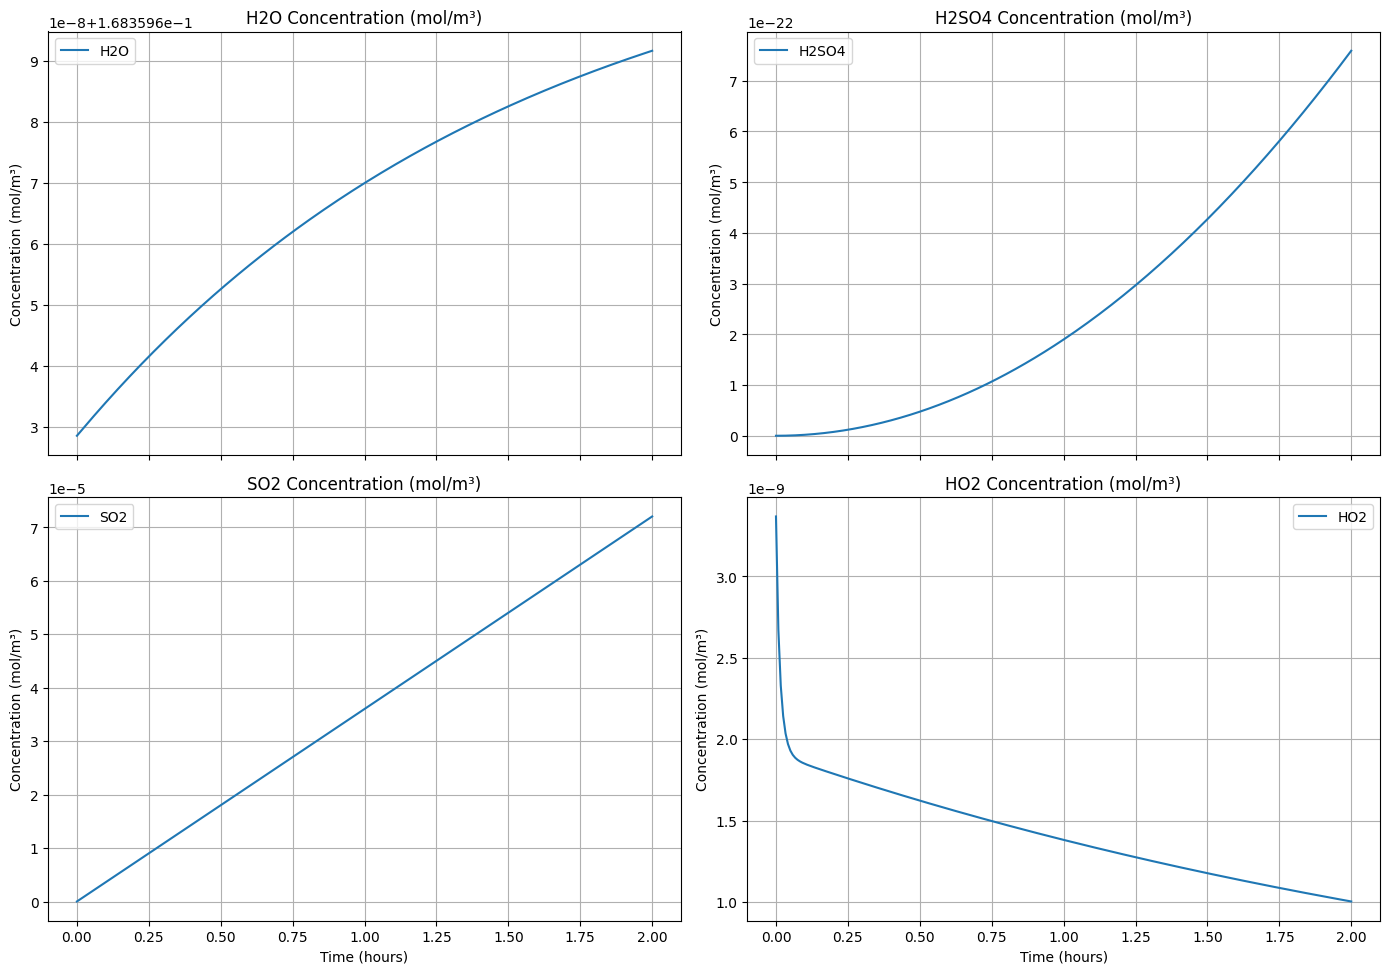

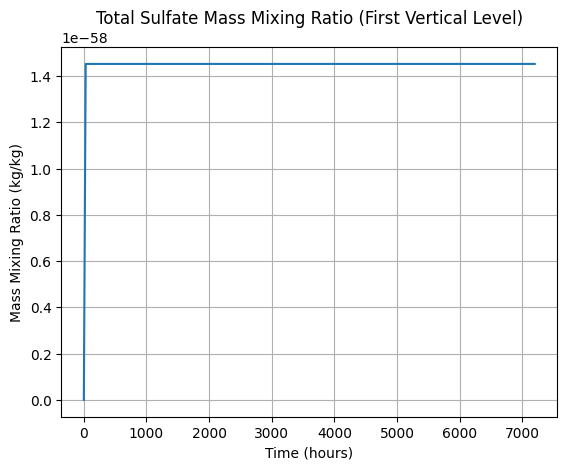

In [21]:
concs, plot_times, sulfate_data = run_box_model()
plot_results(concs, plot_times, sulfate_data)